In [49]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [53]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
batch_size = 4
val_part = 0.2

trainset = torchvision.datasets.CIFAR10(root = './data', train=True,
                                       download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)

train_size = len(trainset)
indices = np.arange(train_size)
np.random.shuffle(indices)
split = int(train_size * val_part)
train_ind, val_ind = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_ind)
val_sampler = SubsetRandomSampler(val_ind)

train_loader = torch.utils.data.DataLoader(trainset, 
                                          batch_size = batch_size,
                                          sampler = train_sampler,
                                          num_workers = 2)

val_loader = torch.utils.data.DataLoader(trainset, 
                                          batch_size = batch_size,
                                          sampler = val_sampler,
                                          num_workers = 2)

test_loader = torch.utils.data.DataLoader(testset, 
                                         batch_size = batch_size,
                                         num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [54]:
from collections import defaultdict

train_iter = iter(train_loader)
val_iter = iter(val_loader)

train_classes = defaultdict(int)
val_classes = defaultdict(int)

for _, labels in train_iter:
    for i in labels:
        train_classes[classes[i]] += 1

for _, labels in val_iter:
    for i in labels:
        val_classes[classes[i]] += 1

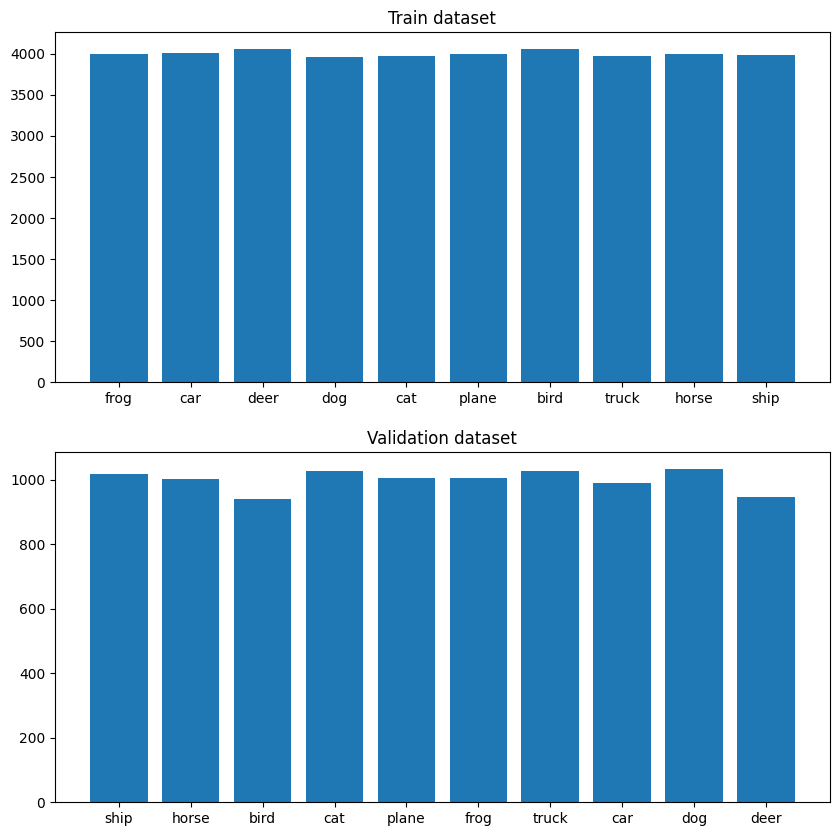

In [61]:
fig, ax = plt.subplots(2, figsize=(10, 10))

ax[0].bar(train_classes.keys(), train_classes.values())
ax[0].set_title("Train dataset")
ax[1].bar(val_classes.keys(), val_classes.values())
ax[1].set_title("Validation dataset")

plt.show()

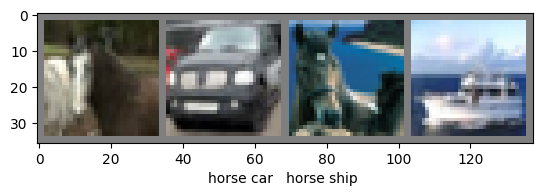

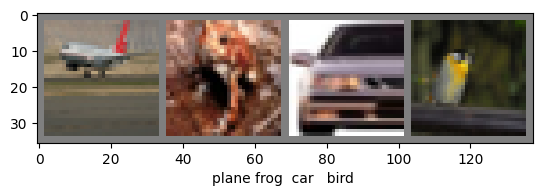

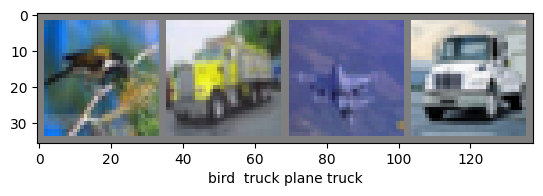

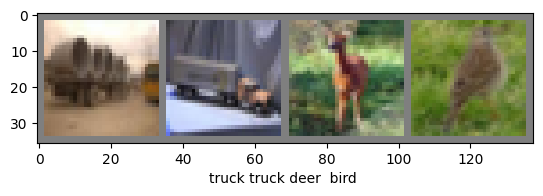

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, xlabel=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if xlabel:
        plt.xlabel(xlabel)
    plt.show()

dataiter = iter(trainloader)

for i in range(4):
    images, labels = next(dataiter)
    xlabel = ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size))
    imshow(torchvision.utils.make_grid(images), xlabel)

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [ ]:
4x32x32x3

[(W−K+2P)/S]+1

(32-3+2*0)/1 + 1 = 30 -> после первого конв слоя будет размер изображения 30х30x6

30x30x6

In [40]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [41]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.222
[1,  4000] loss: 1.906
[1,  6000] loss: 1.687
[1,  8000] loss: 1.618
[1, 10000] loss: 1.550
[1, 12000] loss: 1.504
[2,  2000] loss: 1.439
[2,  4000] loss: 1.409
[2,  6000] loss: 1.363
[2,  8000] loss: 1.356
[2, 10000] loss: 1.339
[2, 12000] loss: 1.307
Finished Training


In [48]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = Net().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [22]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

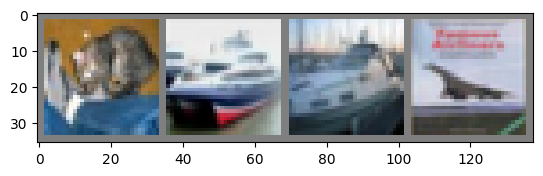

GroundTruth:  cat   ship  ship  plane


In [24]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [25]:
net = Net()
net.load_state_dict(torch.load(PATH))

/tmp/ipykernel_6792/238682776.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [26]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  car   ship 


In [27]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


In [28]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 58.6 %
Accuracy for class: car   is 61.3 %
Accuracy for class: bird  is 37.7 %
Accuracy for class: cat   is 25.1 %
Accuracy for class: deer  is 59.2 %
Accuracy for class: dog   is 52.1 %
Accuracy for class: frog  is 52.4 %
Accuracy for class: horse is 64.2 %
Accuracy for class: ship  is 64.3 %
Accuracy for class: truck is 72.6 %
